In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  
from sklearn.preprocessing import minmax_scale
%matplotlib inline
from scipy import stats
from datetime import datetime
import os

from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import itertools 
from time import time
from functools import reduce 
import operator

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


## Import Model

In [2]:
from sklearn.svm import SVR # Import model
from sklearn.multioutput import RegressorChain
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.base import TransformerMixin
from sklearn.linear_model import Ridge # Import model
from sklearn.neighbors import KNeighborsRegressor # Import model
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor # Import model
from sklearn.neural_network import MLPRegressor # Import model
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import paired_distances

## Reading data

In [3]:
trainDf = pd.read_csv ("data/ML-CUP20-TR.csv")

# Normalize
colnames=trainDf.columns.values
trainDf=pd.DataFrame(minmax_scale(trainDf, feature_range=(0,1), axis=0))
trainDf.columns=colnames
trainDf.describe()


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y1,Y2
count,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000
mean,0.493986,0.455558,0.422902,0.532771,0.542641,0.556990,0.448495,0.479733,0.477938,0.494039,0.425603,0.351685
std,0.229482,0.218699,0.211772,0.174884,0.209266,0.168283,0.216930,0.206977,0.214500,0.224177,0.287916,0.271691
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.277706,0.261214,0.236137,0.407235,0.353918,0.448039,0.244393,0.305093,0.281794,0.286610,0.164375,0.130400
50%,0.515967,0.464428,0.416107,0.527146,0.576631,0.533931,0.475399,0.480954,0.482409,0.536919,0.366169,0.296888
75%,0.686938,0.638466,0.584685,0.648318,0.715638,0.665114,0.635441,0.637042,0.659932,0.668569,0.672862,0.502768
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
dataset=trainDf.values
Xtot = dataset[:, 0:10]
Ytot = dataset[:, 10:12]
ytot = dataset[:, 10]


## Split data 60%

In [5]:
first_split = trainDf.sample(frac=0.6,random_state=200)
second_split=trainDf.drop(first_split.index)
trainset = first_split.to_numpy()
testset = second_split.to_numpy()




In [6]:
X = trainset[:, 0:10]
Y = trainset[:, 10:12]  # Y1 and Y2 train
y = trainset[:, 10]     # Y1 train
yb = trainset[:, 11]    # Y2 

Xtest= dataset[:, 0:10]
Ytest = dataset[:, 10:12] # Y1 and Y2 test
ytest= dataset[:, 10]     # Y1 test
ybtest= dataset[:, 11]    # Y2 test


In [7]:
 X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.25, random_state=1)

## Transformers

In [8]:
class svrTransformer(SVR, TransformerMixin):
  
    def transform(self, X, *_):
        #params = [{'C' : [1.0], 'epsilon' : [0.1], 'gamma' : [0.1], 'kernel' :['rbf']}]
        self.set_params(C=1.0,epsilon=0.1,gamma=0.1,kernel='rbf')
        #print(self.get_params())
        return self.predict(X).reshape(len(X), -1)

class RidgeTransformer(Ridge, TransformerMixin): 
    def transform(self, X, *_):
        self.set_params(alpha=50,fit_intercept=True,max_iter=50,normalize=False,solver='sparse_cg')
        return self.predict(X).reshape(len(X), -1)

class kNTransformer(KNeighborsRegressor, TransformerMixin):
     def transform(self, X, *_):
          self.set_params(leaf_size=3,n_neighbors=18,p=2,weights='distance')
          return self.predict(X).reshape(len(X), -1)   

class rFTransformer(RandomForestRegressor, TransformerMixin):
     def transform(self, X, *_):
          self.set_params(bootstrap=False,max_depth=32,max_features='sqrt',min_samples_leaf=1, min_samples_split=2,n_estimators=170 )
          return self.predict(X).reshape(len(X), -1)   


class mlPTransformer(MLPRegressor, TransformerMixin):
     def transform(self, X, *_):
          self.set_params(activation='tanh',early_stopping=True,hidden_layer_sizes=20,learning_rate_init=0.1, max_iter=3000,momentum=0.001,tol=1e-05 )
          return self.predict(X).reshape(len(X), -1)    



## Pipelines and transformers

In [9]:
combined_features = FeatureUnion([("svm", svrTransformer()), 
                                   ("rT", RidgeTransformer()), 
                                   ("knT", kNTransformer()), 
                                   ("mlpT", mlPTransformer()), 
                                   ("rfT", rFTransformer())])

# setup the pipeline
pipeline = Pipeline(steps = [('features', combined_features),
                             ('estimator', KNeighborsRegressor())])

# parameter for a new model 
#param_grid_lr = [{
#          'features__svm__kernel':['rbf','sigmoid'],  # SVR
#          'features__svm__C':np.linspace(1, 100, 10).tolist(),
#          'features__svm__gamma': [0.01, 0.1, 1.0, 10.0, 100.0, 'scale'],
#          'features__svm__epsilon':[0.1,0.2] }]

leaf_size = list(range(3,5))
n_neighbors = list(range(3,40))
p=[1,2]

grid_params = [{
           'estimator__leaf_size':leaf_size, 
          'estimator__n_neighbors':n_neighbors,    # KN Regressor
          'estimator__weights':['uniform', 'distance'],
          'estimator__p':p}]



## Grid search CV

In [14]:
gs_lR = GridSearchCV(pipeline, grid_params, scoring='neg_mean_squared_error', cv=10, verbose =1, return_train_score=True,n_jobs=-1) 
gs_lR.fit(X_train,y)


ValueError: Found input variables with inconsistent numbers of samples: [685, 914]

In [10]:
gs_lR.best_params_

{'estimator__n_neighbors': 12,
 'estimator__p': 1,
 'estimator__weights': 'uniform'}

## Learning curve for the best parameter from GS

In [25]:
trainDf = pd.read_csv ("data/chain/train.csv").to_numpy()
testDF = pd.read_csv ("data/chain/test.csv").to_numpy()

X = trainDf[:, 0:10]
Y = trainDf[:, 10:12]  # Y1 and Y2 train
y = trainDf[:, 10]     # Y1 train
yb = trainDf[:, 11]    # Y2 

Xtest= testDF[:, 0:10]
Ytest = testDF[:, 10:12] # Y1 and Y2 test
ytest= testDF[:, 10]     # Y1 test
ybtest= testDF[:, 11]    # Y2 test

  
params = {'estimator__leaf_size': 30,
'estimator__n_neighbors': 30,  
'estimator__leaf_size': 4, 
 'estimator__p': 1,
 'estimator__weights': 'uniform'}

model = KNeighborsRegressor(leaf_size=4,n_neighbors=30, p=1,weights='uniform')
model.fit(X, y)
y1Pred = model.predict(Xtest)
train_sizes, train_scores, test_scores = learning_curve(model, X, y, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)

In [12]:
pd.DataFrame(y1Pred).to_csv("data/chain/Y1.csv")

In [13]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)


### Plot

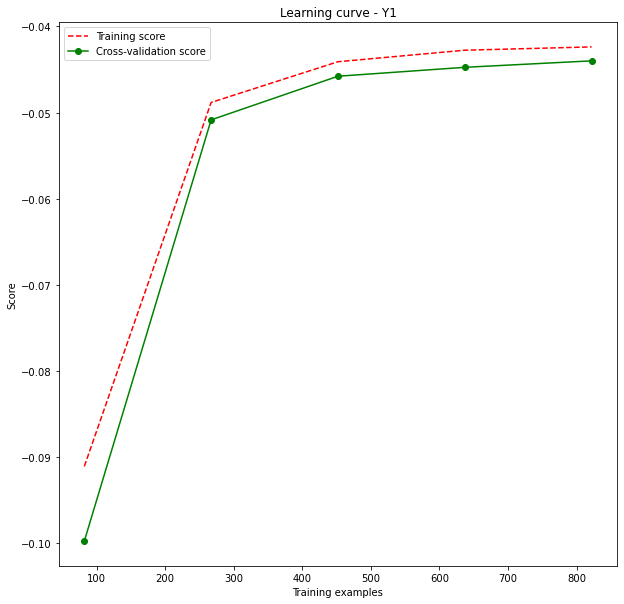

In [14]:
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_scores_mean, '--', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
plt.title("Learning curve - Y1")
plt.xlabel("Training examples")
plt.ylabel("Score")                     
plt.legend(loc="best")
plt.show()


## MEE

In [ ]:
yTrain = model.predict()

In [39]:
yPred = pd.read_csv ("data/chain/yPred.csv").to_numpy()
#mee12 = euclidean_distances(yPred, Ytest)
mee2 = paired_distances(yPred, Ytest,  metric='euclidean')

In [40]:
mee22 = mee
mee22

0.4610917316260718